In [1]:
import os
import numpy as np
import pandas as pd
import pyswarm
import scipy.stats as sps

import argus_shapes
import pulse2percept.implants as p2pi
from pulse2percept.retina import ret2dva, dva2ret

import sklearn.base as sklb
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-06-18 22:33:52,101 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))

In [3]:
subjects = subjectdata.index.sort_values()

In [4]:
scale = 3

In [5]:
y_trial = {}
y_mean = {}
for subject in subjects:
    X, y = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'),
                                  subject=subject, amp=2.0, random_state=42)
    y_trial[subject] = y
    _, y_mean[subject] = argus_shapes.calc_mean_images(X, y, max_area=1.5)

In [6]:
def calc_tangent(xc, yc, model, bundles):
    axon = model._finds_closest_axons(bundles, xret=xc, yret=yc)[0]
    idx = np.argmin((axon[:, 0] - xc) ** 2 + (axon[:, 1] - yc) ** 2)
    if idx == 0:
        dx = axon[1, :] - axon[0, :]
    elif idx == axon.shape[0] - 1:
        dx = axon[-1, :] - axon[-2, :]
    else:
        dx = (axon[idx + 1, :] - axon[idx - 1, :]) / 2
    
    dx[1] *= -1
    tangent = np.arctan2(*dx[::-1])
    if tangent < np.deg2rad(-90):
        tangent += np.deg2rad(180)
    if tangent > np.deg2rad(90):
        tangent -= np.deg2rad(180)
    return tangent

In [7]:
def calc_subject_tangents(subject, y_mean, subjectdata):
    implant_type = subjectdata.loc[subject, 'implant_type']
    implant_rot = subjectdata.loc[subject, 'implant_rot']
    implant = implant_type(x_center=subjectdata.loc[subject, 'implant_x'], 
                           y_center=subjectdata.loc[subject, 'implant_y'],
                           rot=implant_rot)
    model = argus_shapes.models.ModelC(engine='cython')
    model.fit(pd.DataFrame([{'electrode': 'A01'}]))
    bundles = model._grows_axon_bundles()
    x_center = [implant[e['electrode']].x_center for (_, e) in y_mean[subject].iterrows()]
    y_center = [implant[e['electrode']].y_center for (_, e) in y_mean[subject].iterrows()]
    orient_tangent = [calc_tangent(xc, yc, model, bundles)
                      for xc, yc in zip(x_center, y_center)]
    return np.array(orient_tangent)

In [8]:
import pulse2percept as p2p
from matplotlib import patches
def plot_orientation(subject, y_mean, subjectdata, ax):
    implant_type = subjectdata.loc[subject, 'implant_type']
    implant_rot = subjectdata.loc[subject, 'implant_rot']
    implant = implant_type(x_center=subjectdata.loc[subject, 'implant_x'], 
                           y_center=subjectdata.loc[subject, 'implant_y'],
                           rot=implant_rot)
    sim = p2p.Simulation(implant)
    sim.set_optic_fiber_layer(sampling=500, n_rho=71, n_axons=301, x_range=(0, 0), y_range=(0, 0),
                              loc_od=(subjectdata.loc[subject, 'loc_od_x'], 
                                      subjectdata.loc[subject, 'loc_od_y']))
    sim.plot_fundus(ax=ax, annotate=True, upside_down=True)
    if isinstance(implant, p2p.implants.ArgusII):
        patch = patches.Rectangle((implant['A1'].x_center-400, implant['A1'].y_center-200),
                                  525*9+800, 525*5+800, color='gray', alpha=0.5,
                                  angle=np.rad2deg(implant_rot), zorder=10)
    else:
        patch = patches.Rectangle((implant['A1'].x_center-700, implant['A1'].y_center+300),
                                  900*4, 900*4, color='gray', alpha=0.5,
                                  angle=np.rad2deg(implant_rot), zorder=10)
    ax.add_patch(patch)
    for _, row in y_mean.iterrows():
        ax.quiver(implant[row['electrode']].x_center, implant[row['electrode']].y_center,
                  np.cos(row['orientation']), np.sin(row['orientation']), width=0.01,
                  color='w', zorder=100, headlength=0, headwidth=1, pivot='middle')
    ax.set_title(subject)

In [9]:
subject = 'S1'
# angles_true, angles_random = shuffle_test(subject, y_mean[subject], subjectdata, n_iter=n_shuffle)

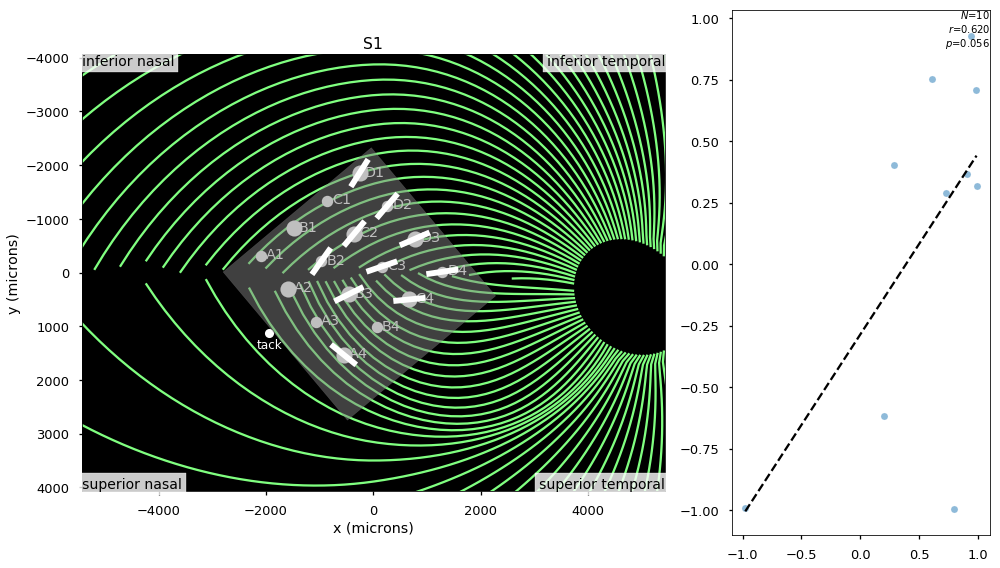

In [10]:
fig = plt.figure(figsize=(14, 8))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
plot_orientation(subject, y_mean[subject], subjectdata, ax1)

ax2 = plt.subplot2grid((1, 3), (0, 2))
orient_true = y_mean[subject]['orientation']
orient_tangent = calc_subject_tangents(subject, y_mean, subjectdata)
argus_shapes.viz.scatter_correlation(np.sin(2 * orient_true), np.sin(2 * orient_tangent), ax2)
# argus_shapes.viz.scatter_correlation(orient_true, orient_tangent, ax2)

fig.tight_layout()
fig.savefig('%s-axons.eps' % subject)

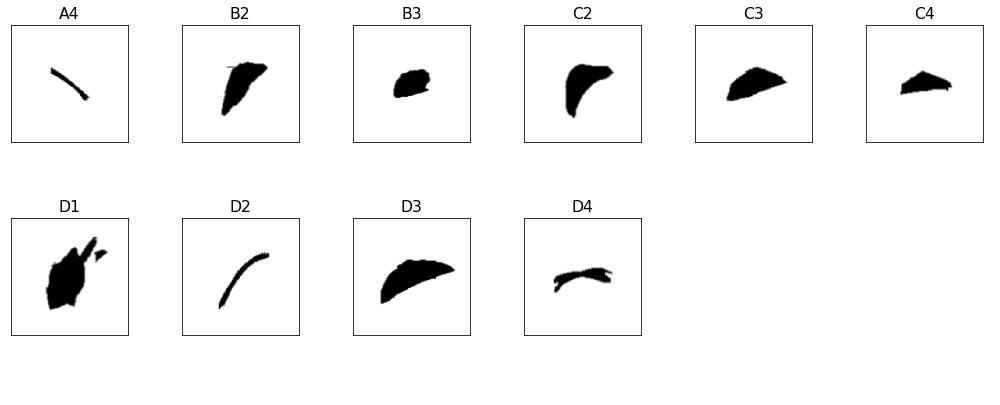

In [11]:
yy = y_mean[subject]
els = yy.electrode.unique()
ncols = 6
nrows = int(np.ceil(len(els) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, 3 * nrows))
for ax in axes.ravel():
    ax.axis('off')
for el, ax in zip(els, axes.ravel()):
    ax.axis('on')
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    img = argus_shapes.imgproc.center_phosphene(img)
    img = argus_shapes.imgproc.scale_phosphene(img, scale)
    ax.imshow(1 - img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('%s-axons-drawings.eps' % subject)

In [12]:
subject = 'S2'

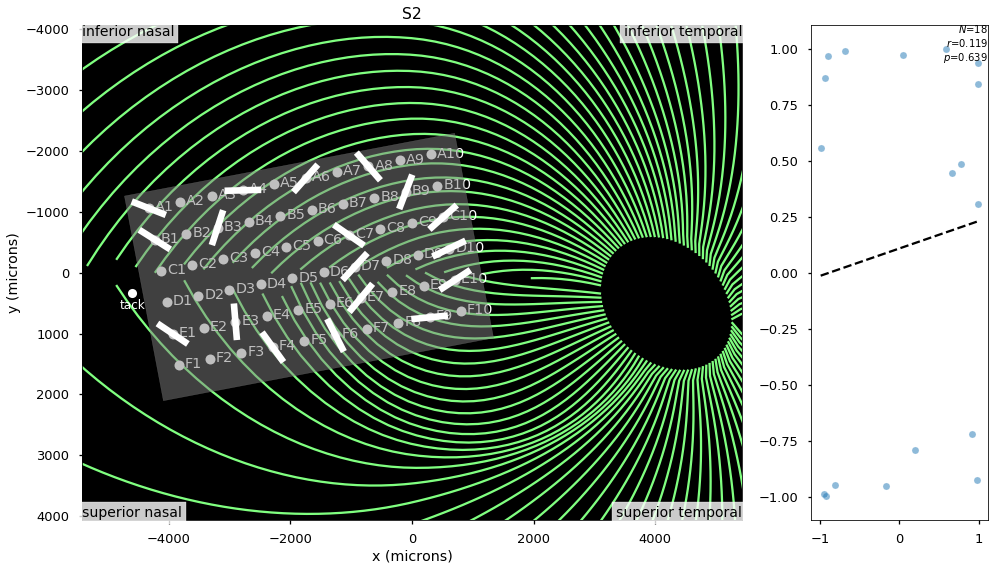

In [13]:
fig = plt.figure(figsize=(14, 8))
ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
plot_orientation(subject, y_mean[subject], subjectdata, ax1)

ax2 = plt.subplot2grid((1, 4), (0, 3))
orient_true = y_mean[subject]['orientation']
orient_tangent = calc_subject_tangents(subject, y_mean, subjectdata)
argus_shapes.viz.scatter_correlation(np.sin(2 * orient_true), np.sin(2 * orient_tangent), ax2)
# argus_shapes.viz.scatter_correlation(orient_true, orient_tangent, ax2)

fig.tight_layout()
fig.savefig('%s-axons.eps' % subject)

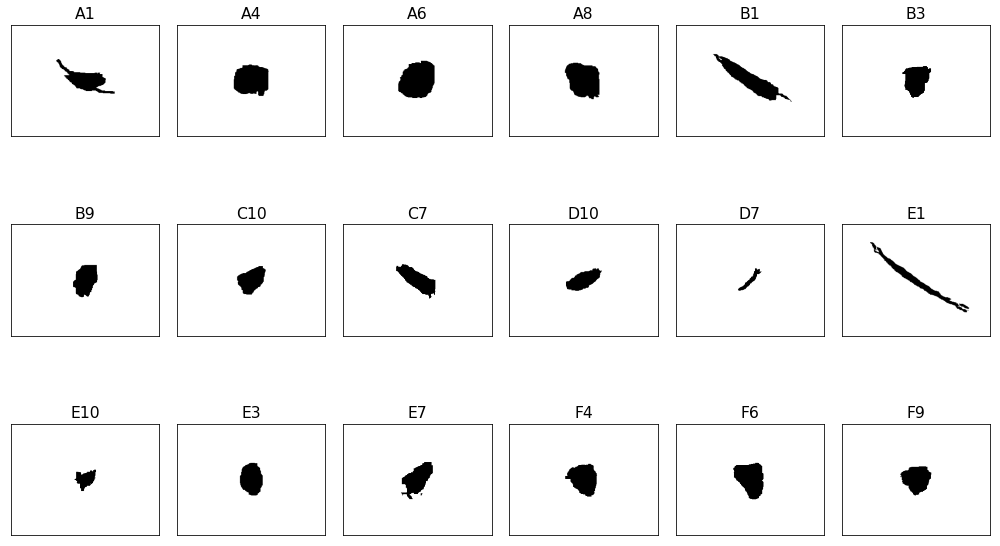

In [14]:
yy = y_mean[subject]
els = yy.electrode.unique()
ncols = 6
nrows = int(np.ceil(len(els) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, 3 * nrows))
for ax in axes.ravel():
    ax.axis('off')
for el, ax in zip(els, axes.ravel()):
    ax.axis('on')
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    img = argus_shapes.imgproc.center_phosphene(img)
    img = argus_shapes.imgproc.scale_phosphene(img, scale)
    ax.imshow(1 - img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('%s-axons-drawings.eps' % subject)

In [15]:
subject = 'S3'

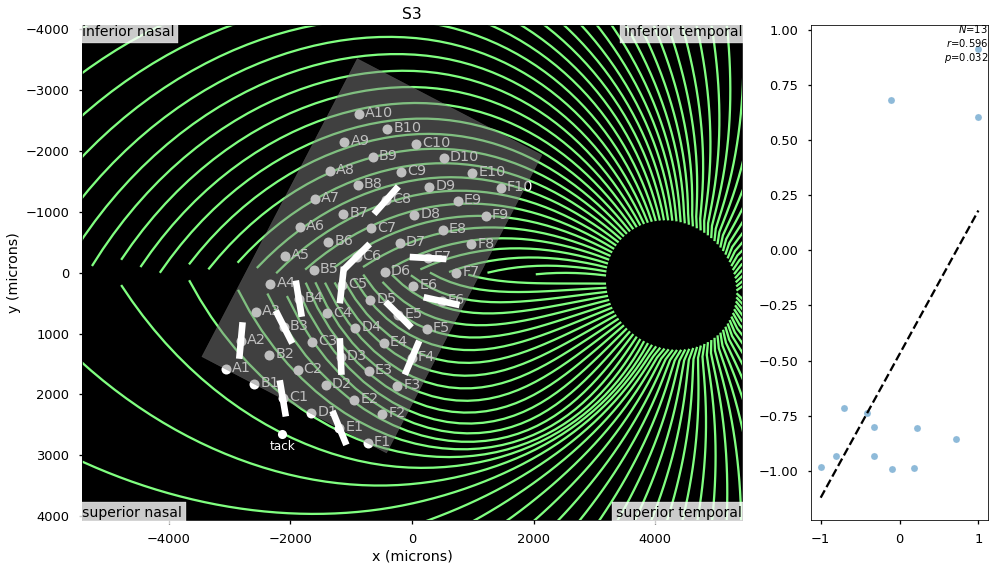

In [16]:
fig = plt.figure(figsize=(14, 8))
ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
plot_orientation(subject, y_mean[subject], subjectdata, ax1)

ax2 = plt.subplot2grid((1, 4), (0, 3))
orient_true = y_mean[subject]['orientation']
orient_tangent = calc_subject_tangents(subject, y_mean, subjectdata)
argus_shapes.viz.scatter_correlation(np.sin(2 * orient_true), np.sin(2 * orient_tangent), ax2)
# argus_shapes.viz.scatter_correlation(orient_true, orient_tangent, ax2)

fig.tight_layout()
fig.savefig('%s-axons.eps' % subject)

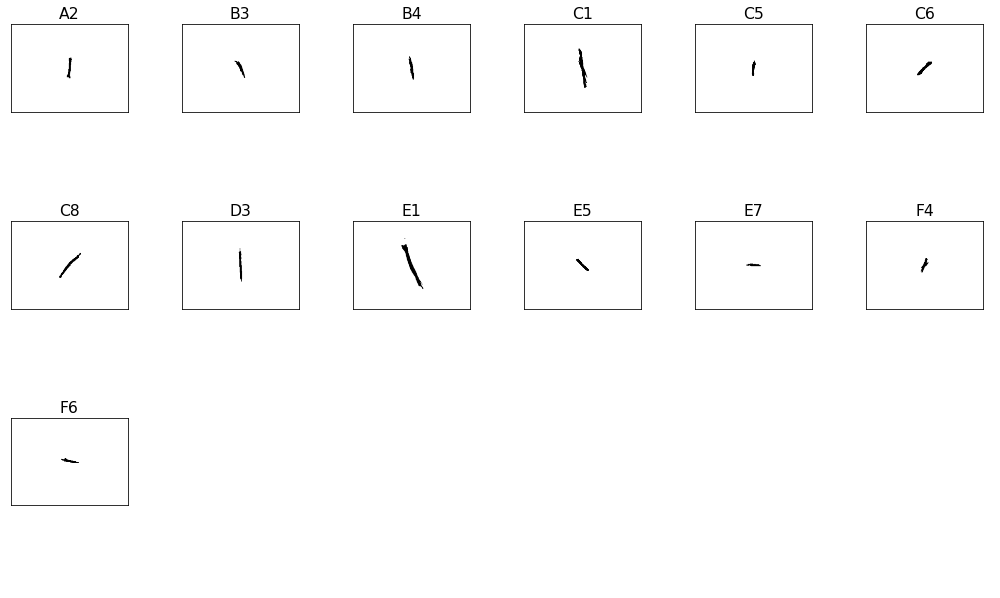

In [17]:
yy = y_mean[subject]
els = yy.electrode.unique()
ncols = 6
nrows = int(np.ceil(len(els) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, 3 * nrows))
for ax in axes.ravel():
    ax.axis('off')
for el, ax in zip(els, axes.ravel()):
    ax.axis('on')
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    img = argus_shapes.imgproc.center_phosphene(img)
    img = argus_shapes.imgproc.scale_phosphene(img, scale)
    ax.imshow(1 - img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('%s-axons-drawings.eps' % subject)

In [18]:
subject = 'S4'

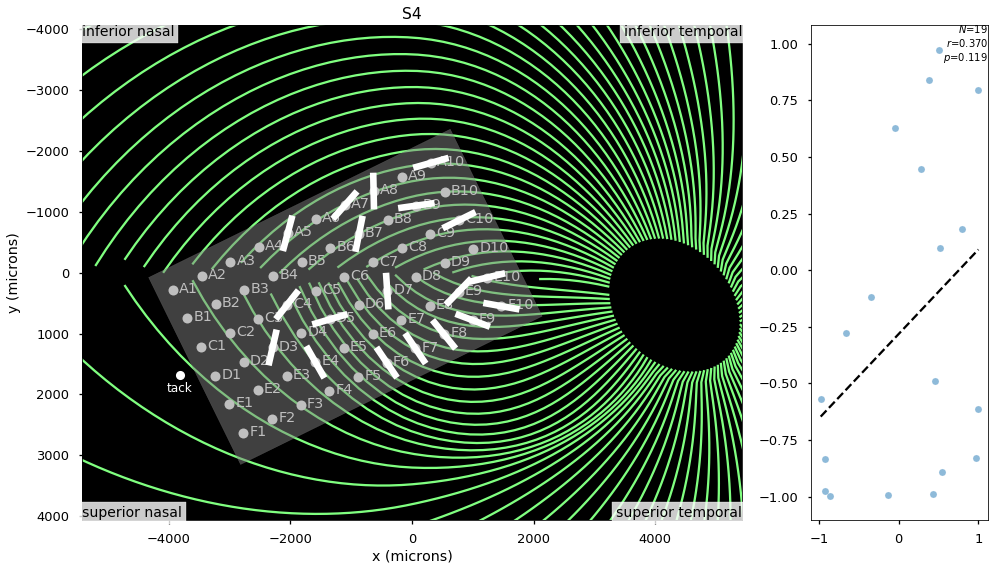

In [19]:
fig = plt.figure(figsize=(14, 8))
ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
plot_orientation(subject, y_mean[subject], subjectdata, ax1)

ax2 = plt.subplot2grid((1, 4), (0, 3))
orient_true = y_mean[subject]['orientation']
orient_tangent = calc_subject_tangents(subject, y_mean, subjectdata)
argus_shapes.viz.scatter_correlation(np.sin(2 * orient_true), np.sin(2 * orient_tangent), ax2)
# argus_shapes.viz.scatter_correlation(orient_true, orient_tangent, ax2)

fig.tight_layout()
fig.savefig('%s-axons.eps' % subject)

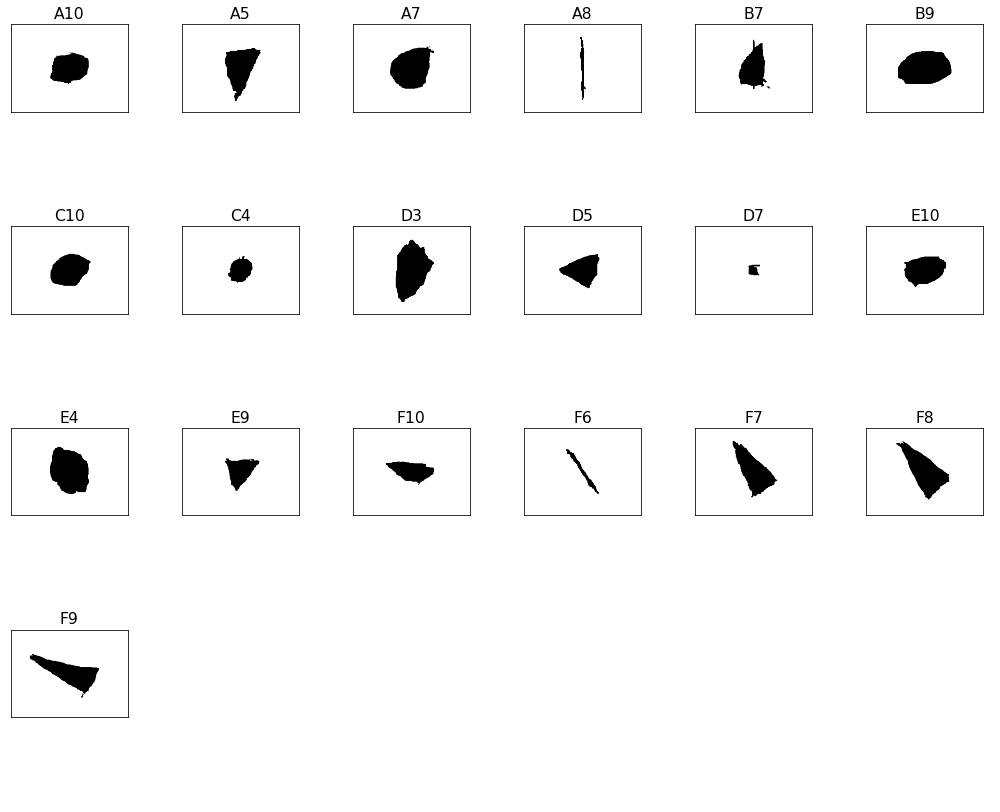

In [20]:
yy = y_mean[subject]
els = yy.electrode.unique()
ncols = 6
nrows = int(np.ceil(len(els) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, 3 * nrows))
for ax in axes.ravel():
    ax.axis('off')
for el, ax in zip(els, axes.ravel()):
    ax.axis('on')
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    img = argus_shapes.imgproc.center_phosphene(img)
    img = argus_shapes.imgproc.scale_phosphene(img, scale)
    ax.imshow(1 - img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('%s-axons-drawings.eps' % subject)